In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,2,1"

In [2]:
import keras.backend as K
if('tensorflow' == K.backend()):
    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session

    config = tf.ConfigProto()  
    config.gpu_options.allow_growth = True
    print(config)
    sess = tf.Session(config=config)

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


gpu_options {
  allow_growth: true
}



In [3]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Lambda
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, concatenate, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import keras
import keras.backend as K

from imgaug import augmenters as iaa

from IPython import display
import pylab as pl

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.core.pylabtools import figsize
import os
import glob
import cv2
import numpy as np

In [4]:
def build_noise():
    inputs = Input((img_rows, img_cols,4))
    #inputs_norm = Lambda(lambda x: x/255)(inputs)
    k=32
    mask = Lambda(lambda x: x[:,:,:,3:4])(inputs)
    
    conv1 = Conv2D(k, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(k, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = Conv2D(k, (2, 2), strides=(2, 2), activation='relu', padding='same')(conv1)

    conv2 = Conv2D(k*2, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(k*2, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = Conv2D(k*2, (2, 2), strides=(2, 2), activation='relu', padding='same')(conv2)

    conv3 = Conv2D(k*4, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(k*4, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = Conv2D(k*4, (2, 2), strides=(2, 2), activation='relu', padding='same')(conv3)

    conv4 = Conv2D(k*8, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(k*8, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = Conv2D(k*8, (2, 2), strides=(2, 2), activation='relu', padding='same')(conv4)

    conv5 = Conv2D(k*16, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(k*16, (3, 3), activation='relu', padding='same')(conv5)
    pool5 = Conv2D(k*16, (2, 2), strides=(2, 2), activation='relu', padding='same')(conv5)
    
    conv6 = Conv2D(k*32, (3, 3), activation='relu', padding='same')(pool5)
    conv6 = Conv2D(k*32, (3, 3), activation='relu', padding='same')(conv6)
    
    up7 = concatenate([Conv2DTranspose(k*16, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv6), conv5], axis=3)
    conv7 = Conv2D(k*16, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(k*16, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(k*8, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv7), conv4], axis=3)
    conv8 = Conv2D(k*8, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(k*8, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(k*4, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv8), conv3], axis=3)
    conv9 = Conv2D(k*4, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(k*4, (3, 3), activation='relu', padding='same')(conv9)

    up10 = concatenate([Conv2DTranspose(k*2, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv9), conv2], axis=3)
    conv10 = Conv2D(k*2, (3, 3), activation='relu', padding='same')(up10)
    conv10 = Conv2D(k*2, (3, 3), activation='relu', padding='same')(conv10)

    up11 = concatenate([Conv2DTranspose(k, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv10), conv1], axis=3)
    conv11 = Conv2D(k, (3, 3), activation='relu', padding='same')(up11)
    conv11 = Conv2D(k, (3, 3), activation='relu', padding='same')(conv11)

    conv12 = Conv2D(3, (1, 1), activation='sigmoid')(conv11)
    
    out = concatenate([conv12, mask])
    
    model = Model(inputs=inputs, outputs=out)

    
    return model

In [5]:
def build_denoise():
    inputs = Input((img_rows, img_cols,4))
    #inputs_norm = Lambda(lambda x: x/255)(inputs)
    k=32
    
    data = Lambda(lambda x: x[:,:,:,:3])(inputs)
    mask = Lambda(lambda x: x[:,:,:,3:])(inputs)
    
    conv1 = Conv2D(k, (3, 3), activation='relu', padding='same')(data)
    conv1 = Conv2D(k, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = Conv2D(k, (2, 2), strides=(2, 2), activation='relu', padding='same')(conv1)

    conv2 = Conv2D(k*2, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(k*2, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = Conv2D(k*2, (2, 2), strides=(2, 2), activation='relu', padding='same')(conv2)

    conv3 = Conv2D(k*4, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(k*4, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = Conv2D(k*4, (2, 2), strides=(2, 2), activation='relu', padding='same')(conv3)

    conv4 = Conv2D(k*8, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(k*8, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = Conv2D(k*8, (2, 2), strides=(2, 2), activation='relu', padding='same')(conv4)

    conv5 = Conv2D(k*16, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(k*16, (3, 3), activation='relu', padding='same')(conv5)
    pool5 = Conv2D(k*16, (2, 2), strides=(2, 2), activation='relu', padding='same')(conv5)
    
    conv6 = Conv2D(k*32, (3, 3), activation='relu', padding='same')(pool5)
    conv6 = Conv2D(k*32, (3, 3), activation='relu', padding='same')(conv6)
    
    up7 = concatenate([Conv2DTranspose(k*16, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv6), conv5], axis=3)
    conv7 = Conv2D(k*16, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(k*16, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(k*8, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv7), conv4], axis=3)
    conv8 = Conv2D(k*8, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(k*8, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(k*4, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv8), conv3], axis=3)
    conv9 = Conv2D(k*4, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(k*4, (3, 3), activation='relu', padding='same')(conv9)

    up10 = concatenate([Conv2DTranspose(k*2, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv9), conv2], axis=3)
    conv10 = Conv2D(k*2, (3, 3), activation='relu', padding='same')(up10)
    conv10 = Conv2D(k*2, (3, 3), activation='relu', padding='same')(conv10)

    up11 = concatenate([Conv2DTranspose(k, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv10), conv1], axis=3)
    conv11 = Conv2D(k, (3, 3), activation='relu', padding='same')(up11)
    conv11 = Conv2D(k, (3, 3), activation='relu', padding='same')(conv11)

    conv12 = Conv2D(3, (1, 1), activation='sigmoid')(conv11)
    
    out = concatenate([conv12, mask])
    
    model = Model(inputs=inputs, outputs=out)

    
    return model

In [6]:
def load_pass_data(img_dir): 
    data_path = os.path.join(img_dir,'*g')
    files = glob.glob(data_path)
    img_data = []
    for f1 in files:
        name_rule1 = f1[f1.find('CODE'):f1.find('CODE')+6] == 'CODE0_'
        #name_rule2 = f1[f1.find('CODE'):f1.find('CODE')+6] == 'CODE1_'
        if name_rule1:#or name_rule2:
            print (f1)
            img = cv2.imread(f1)
            img = cv2.resize(img, dsize=(512,512), interpolation=cv2.INTER_CUBIC)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_data.append(img)

    raw_data = np.asarray(img_data)
    return raw_data

def load_defect_data(img_dir): 
    data_path = os.path.join(img_dir, '*g')
    files = glob.glob(data_path)
    img_data = []
    for f1 in files:
        name_rule1 = f1[f1.find('CODE'):f1.find('CODE')+6] == 'CODE0_'
        #name_rule2 = f1[f1.find('CODE'):f1.find('CODE')+6] == 'CODE1_'
        if True:#name_rule1:#or name_rule2:
            print (f1)
            img = cv2.imread(f1)
            if img.shape!=(600,600,3):
                print (img.shape)
                img=img[50:650,50:650,:]
            img = cv2.resize(img, dsize=(512,512), interpolation=cv2.INTER_CUBIC)
            img = img[128:384,128:384,:]
            #img = img[192:320,192:320,:]
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_data.append(img)
            
            
    data_path = os.path.join(img_dir, '*G')
    files = glob.glob(data_path)
    for f1 in files:
        name_rule1 = f1[f1.find('CODE'):f1.find('CODE')+6] == 'CODE0_'
        #name_rule2 = f1[f1.find('CODE'):f1.find('CODE')+6] == 'CODE1_'
        if True:#name_rule1:#or name_rule2:
            print (f1)
            img = cv2.imread(f1)
            if img.shape!=(600,600,3):
                print (img.shape)
                img=img[50:650,50:650,:]
                print (img.shape)
            img = cv2.resize(img, dsize=(512,512), interpolation=cv2.INTER_CUBIC)
            img = img[128:384,128:384,:]
            #img = img[192:320,192:320,:]
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_data.append(img)

    raw_data = np.asarray(img_data)
    return raw_data

In [7]:
def get_image_mask(path_to_img, shape=(512, 512, 3), labels=False):
    img = mpimg.imread(path_to_img)
    
    
    
    if labels:
        path_to_json = path_to_img.replace('jpg', 'json')
    
        if os.path.exists(path_to_json):
            with open(path_to_json) as json_file:
                json_get = json.load(json_file)
                pts_list = [np.array(pts['points'], np.int32) for pts in json_get['shapes']]

            mask = np.zeros_like(img, dtype=np.uint8)

            mask = cv2.fillPoly(mask, pts_list, (255, 255, 255))
            mask = cv2.resize(mask, (shape[0], shape[1]))[:,:,0:1]
            mask[mask > 0] = 1.
            img = cv2.resize(img, (shape[0], shape[1]))
            return img, mask
        
        else:
            mask = np.zeros_like(img, dtype=np.uint8)
            mask = cv2.resize(mask, (shape[0], shape[1]))[:,:,0:1]
            img = cv2.resize(img, (shape[0], shape[1]))
            return img, mask
    else:
        img = cv2.resize(img, (shape[0], shape[1]))
        return img
    
def load_images(path_to_images, shape=(512, 512), labels=True):
    '''load image from specified directory

    Args:
        path_to_images (string):
        shape (tuple):

    return:
        dataset (numpy 3d array):

    Notes:

    '''

    image_files = [x for x in os.listdir(path_to_images) if (os.path.splitext(x)[1] == '.jpg')]
    images = np.empty(shape=(len(image_files),
                                shape[0],
                                shape[1],
                                3),
                      dtype=np.uint8)
    masks = np.empty(shape=(len(image_files),
                              shape[0],
                              shape[1],
                              1),
                      dtype=np.uint8)
    images_path = np.empty(shape=(len(image_files)), dtype=object)
    

    if labels:
        masks_path = np.empty(shape=(len(image_files)), dtype=object)
        for idx, image_path in enumerate(glob.glob(path_to_images + '*.jpg')):
            images_path[idx] = image_path       
            images[idx], masks[idx] = get_image_mask(image_path, labels=labels)
        return images, masks
    else:
        for idx, image_path in enumerate(glob.glob(path_to_images + '*.jpg')):
            images_path[idx] = image_path
            images[idx] = get_image_mask(image_path, labels=labels)
        return images
    
def combined_all_defects(path_to_codes):
    images_list = []
    labels_list = []
    for path_to_code in glob.glob(path_to_codes + '/*'):
        images, labels = load_images(path_to_code + '/')
        images_list.append(images)
        labels_list.append(labels)
    images_all = np.concatenate(images_list, axis=0)
    labels_all = np.concatenate(labels_list, axis=0)
    
    return images_all, labels_all

In [ ]:
PassData, ok_labels = load_images('../workspace/NV_data_0304/training/training_pass_10852/')

In [ ]:
PassData.shape

In [8]:
PassData = []
PassDataPath = [x[0] for x in os.walk('./Huawei_HI1102/HI1102_GOLDEN/')]
PassData = [load_defect_data(f) for f in PassDataPath]
PassData = np.concatenate([x for x in PassData if x.size > 0],axis=0)

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2997_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8734_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5864_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_9082_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5730_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7450_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1744_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5471_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5054_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_679_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5994_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6977_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3336_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6299_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7484_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1317_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5867_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3400_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6105_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6547_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1293_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3615_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6698_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3747_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_0

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2140_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_9128_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_706_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_66_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5110_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1641_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2695_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7871_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1678_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6280_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3212_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2908_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/f

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5854_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1018_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8053_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8649_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7096_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1847_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3536_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6489_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_799_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_304_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7183_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7209_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1257_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3651_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4859_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8041_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3893_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_718_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2217_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_9152_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2273_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8104_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6079_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3954_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_831_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1722_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5410_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5414_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3940_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_528_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7271_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6797_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8221_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5606_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2657_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6004_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1971_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6136_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5421_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2371_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3423_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2008_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_640_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7959_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3757_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2808_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8362_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8970_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_659_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7375_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3860_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_521_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2990_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2162_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7741_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7924_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4212_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7489_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4694_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7583_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6786_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1153_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8633_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1819_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6595_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4790_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1416_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6529_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2467_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3273_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3986_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7118_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_0

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5431_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6779_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8147_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6985_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5042_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_938_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_888_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8058_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3048_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8137_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4811_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8087_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8621_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8079_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7443_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6509_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5998_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6118_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_571_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7021_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6260_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7848_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1192_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_177_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6732_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1630_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2645_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_993_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6368_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4615_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4103_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_762_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8274_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5915_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7135_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8849_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_9176_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4804_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2447_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1800_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8801_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7639_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7100_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1299_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5377_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2779_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2753_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5984_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_0

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5311_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5345_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4988_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6316_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1424_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5470_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6097_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5266_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3339_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4948_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8550_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_272_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_9139_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3613_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1298_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3907_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1666_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5441_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_926_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6303_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8114_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3995_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5903_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2181_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7165_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5200_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5079_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1936_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6159_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3904_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_946_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_9206_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_797_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1611_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5678_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2588_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8393_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2972_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6473_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4466_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8182_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1368_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5536_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2246_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_503_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_577_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1685_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5661_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6005_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8894_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7913_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2811_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2958_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1648_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4308_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1146_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8995_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4408_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8443_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4295_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_0

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3546_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6878_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8377_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6922_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3410_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7975_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1942_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_553_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7038_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6262_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_9116_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2129_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4475_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_524_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8676_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8432_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1202_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8003_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4138_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2461_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2606_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7049_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8972_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1334_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5468_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6336_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_933_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5650_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_584_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4581_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2208_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3456_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5616_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7367_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1541_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_101_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/f

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8588_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1717_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_603_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3525_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8050_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6811_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3036_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2114_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8709_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7902_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1980_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6440_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_864_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6517_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5521_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2355_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6642_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4912_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5519_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4884_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4046_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3520_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_824_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7296_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1470_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4114_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8394_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4806_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3850_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_9106_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6735_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_421_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6196_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5809_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_943_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8957_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3205_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_753_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6390_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5028_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2760_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8505_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2338_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5615_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6031_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5280_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6248_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4473_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5808_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7549_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8040_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_917_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4508_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1226_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8700_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5660_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_277_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6836_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7542_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4628_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6665_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7048_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7114_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_9172_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1374_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8220_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6928_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8097_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5663_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8525_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2818_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_409_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4945_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8202_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3770_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4288_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6866_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7184_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5805_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8517_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2761_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8793_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8340_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7343_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_0

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7672_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8503_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8466_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3111_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8303_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7683_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1427_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_444_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7206_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6939_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_407_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5448_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4697_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_492_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6858_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_385_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7617_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8761_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_9221_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5917_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5254_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3595_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4120_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7229_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1915_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_9064_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4183_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8572_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8067_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2002_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5498_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8166_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_43_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6538_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3916_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2776_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4467_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8876_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3726_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2354_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1711_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4831_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7810_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2766_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_9200_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_545_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6795_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2071_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1020_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8369_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3265_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8098_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8364_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5459_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5259_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2433_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2196_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7466_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4385_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_37_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3643_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7029_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8469_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4812_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4023_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2799_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6577_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6763_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5316_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8128_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_9009_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5279_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_0

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2207_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4932_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8205_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8671_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7749_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8780_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1385_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6502_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5866_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8267_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3817_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5937_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_0

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1003_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7438_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6100_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5774_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4568_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5454_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7214_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5133_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5564_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5378_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_476_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8976_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3366_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2983_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3257_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3610_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5000_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3244_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3249_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6857_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7771_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8690_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8752_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7586_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_0

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5765_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8721_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6016_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3820_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3830_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5944_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6716_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1769_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5517_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2573_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4404_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1513_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_0

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7861_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_365_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_479_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1475_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2970_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7644_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3150_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7524_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1250_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1692_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1172_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8799_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7873_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4040_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_853_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_426_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_816_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6098_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1834_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1142_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_382_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4869_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3451_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6457_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/fr

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5987_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7868_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2360_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4160_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3436_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6252_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8535_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1284_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_9224_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_512_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7521_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8232_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3794_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1797_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2060_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8691_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5676_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3857_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_940_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4240_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7737_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6302_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_601_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_772_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/f

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2955_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1009_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_811_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3875_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5344_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7964_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5717_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1282_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5802_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8490_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8491_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4681_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2885_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8442_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2312_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5789_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6996_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8884_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7766_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2509_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8703_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3465_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1421_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1093_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_0

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6083_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2310_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2359_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5756_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7299_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6287_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8859_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4999_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3808_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6951_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6199_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7994_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_0

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4644_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1133_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8326_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1879_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8141_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1077_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2298_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4058_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1280_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7938_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3040_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6731_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_0

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6765_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2374_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_9227_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6593_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3409_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5206_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1150_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7176_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1963_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6526_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8574_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3032_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_0

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8093_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1022_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3946_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5341_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5801_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6063_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6193_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7327_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1534_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_9055_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2202_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2504_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_0

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3264_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3854_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2654_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1263_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5807_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2848_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7689_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5189_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5248_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_964_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1459_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3888_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1315_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5081_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4090_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3691_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8080_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1922_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2484_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1102_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3680_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4361_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2228_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2636_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_0

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7313_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3912_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1474_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_373_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4366_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8470_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2226_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4714_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4514_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5959_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2441_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7823_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_909_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2407_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3130_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_133_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4487_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4338_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3302_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5022_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2289_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5101_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5538_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1791_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8562_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2187_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2233_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_9199_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4837_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2931_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5810_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3286_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4853_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1452_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_174_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1311_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7667_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1594_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5115_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8901_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3398_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7341_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_9114_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2668_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2868_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8204_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3305_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4379_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_0

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7835_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2993_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5771_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2176_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1845_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7944_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5379_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1859_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7899_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_507_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_590_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5609_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_90_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3346_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5483_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8540_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5393_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2751_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1561_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7578_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2489_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7181_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_612_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1529_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/f

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7984_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6900_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3992_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3965_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2479_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2416_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_555_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5788_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8112_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6920_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2061_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_53_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/f

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_186_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_770_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8571_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2895_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5620_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5307_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_814_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1140_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5680_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8543_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5558_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7014_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/f

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2158_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_9151_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_9087_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_552_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2707_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5474_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6632_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3485_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2108_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6687_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8292_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4770_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4411_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4380_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7196_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3535_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4961_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6250_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2154_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3898_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2131_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_241_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8500_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3924_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7390_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4219_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8002_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6032_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_136_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5790_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1007_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7696_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5739_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1040_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5087_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5591_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4710_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4998_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7587_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8629_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1673_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_9024_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2879_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2370_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4693_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_470_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6433_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1418_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2961_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8352_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5750_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8184_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5579_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4619_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6481_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1228_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4245_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6304_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3629_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5721_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_0

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3076_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4558_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8846_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3136_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7797_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8675_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5698_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2284_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3066_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3960_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8011_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_639_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6264_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4645_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5744_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4053_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8009_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6587_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2306_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2308_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5484_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_789_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2348_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6677_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3801_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_362_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_384_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3903_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6019_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_2503_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5021_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7314_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7623_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1070_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4656_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7394_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/

./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3513_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8197_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_6748_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7624_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_1881_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_4606_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_8268_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_3292_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5539_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_7611_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_9162_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_01/front/TE3Q0792_01_0_0_5002_CODE76.jpg
./Huawei_HI1102/HI1102_GOLDEN/TE3Q0792_0

In [9]:
PassData.shape

(9227, 256, 256, 3)

In [13]:
def aug(data):
    seq1 = iaa.Sometimes(0.5, iaa.Multiply((0.5,1)))
    seq2 = iaa.SimplexNoiseAlpha(iaa.SomeOf(2, [iaa.Add(150), iaa.CoarseDropout((1), size_percent=(1))]),  size_px_max=(5, 25), sigmoid_thresh=7.0, upscale_method="linear")
    Aug1 = seq1.augment_images(data)
    Aug2 = seq2.augment_images(Aug1)
    return Aug2

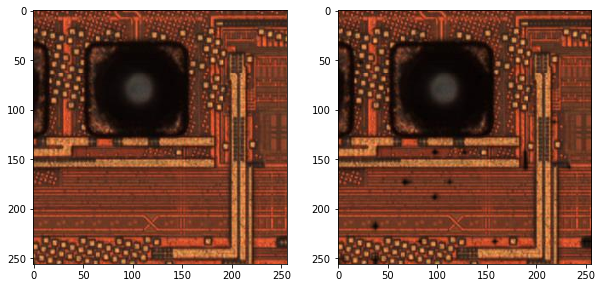

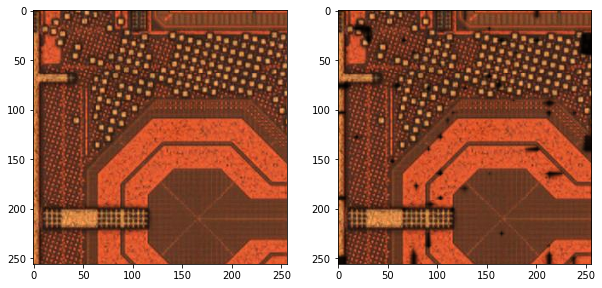

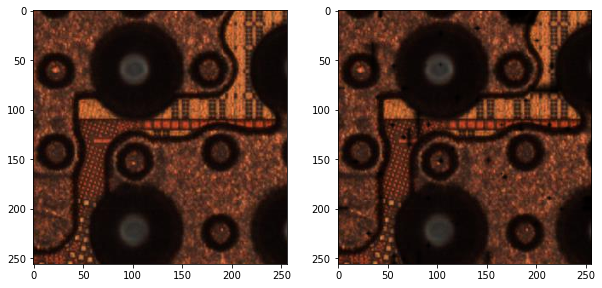

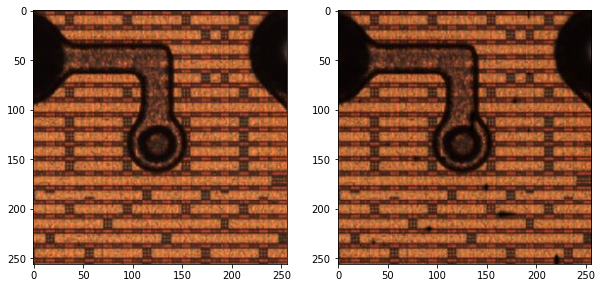

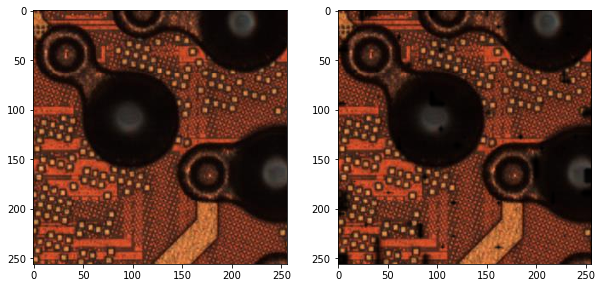

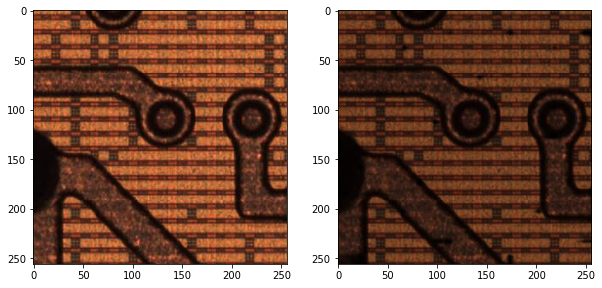

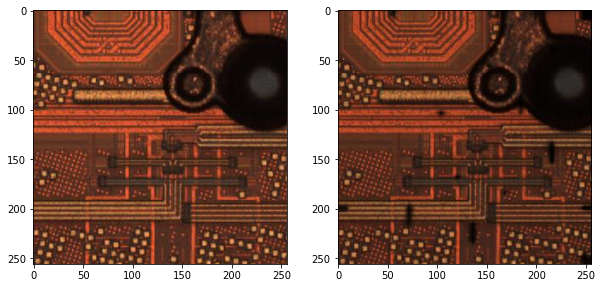

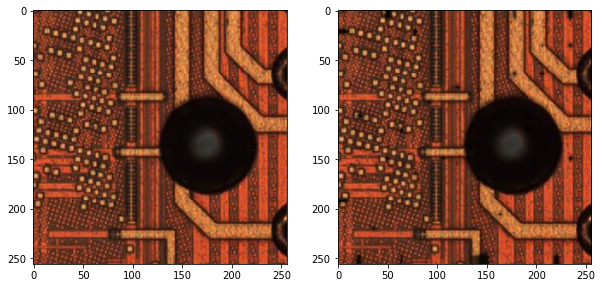

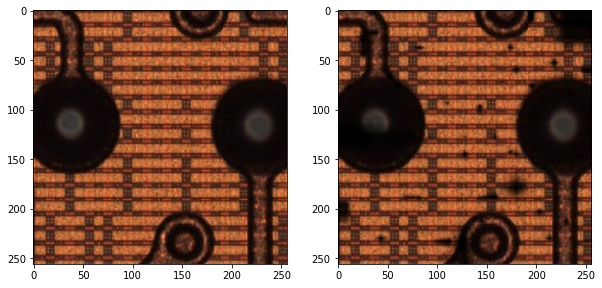

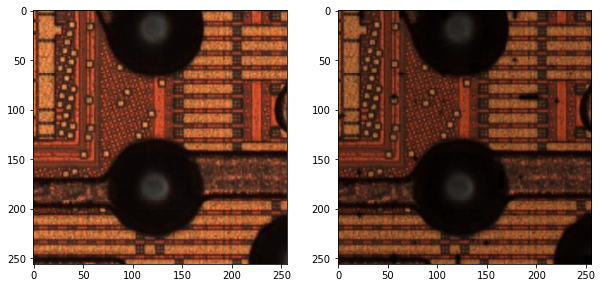

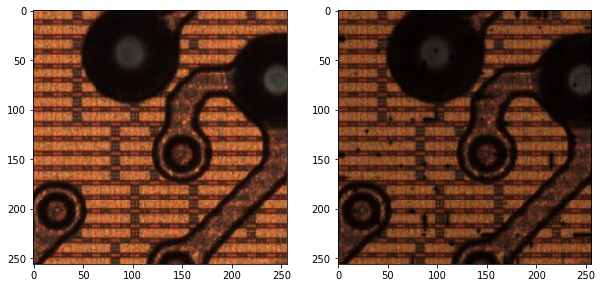

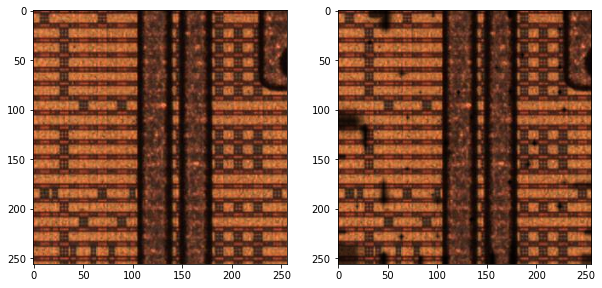

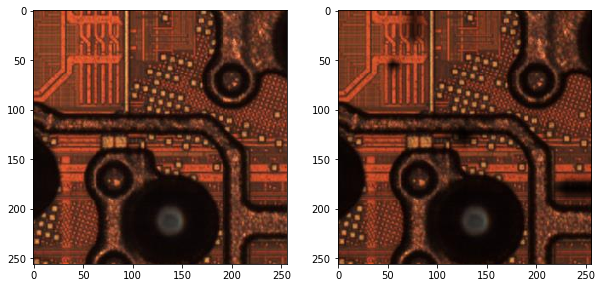

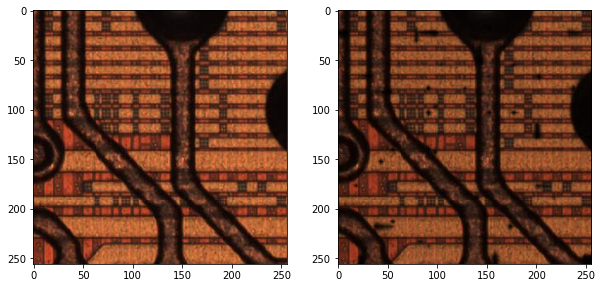

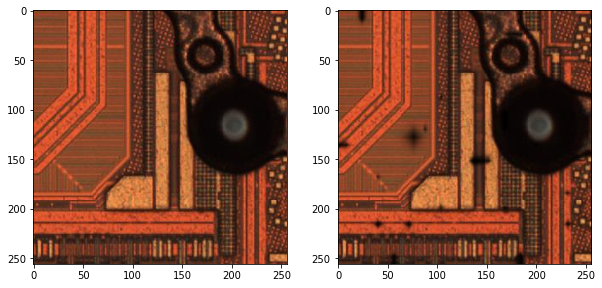

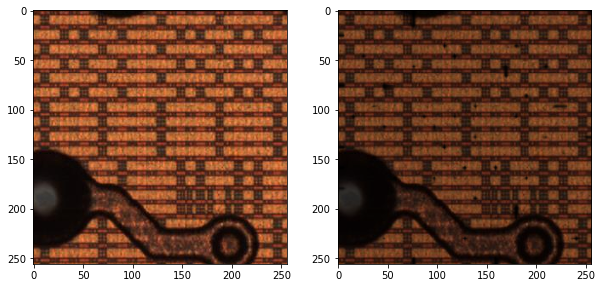

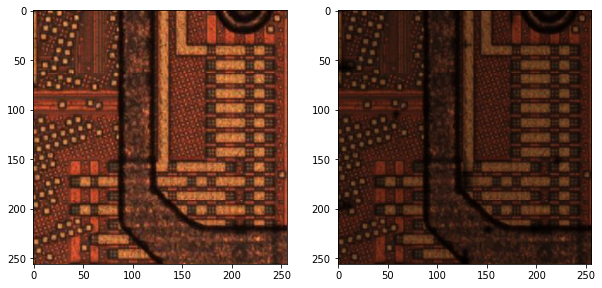

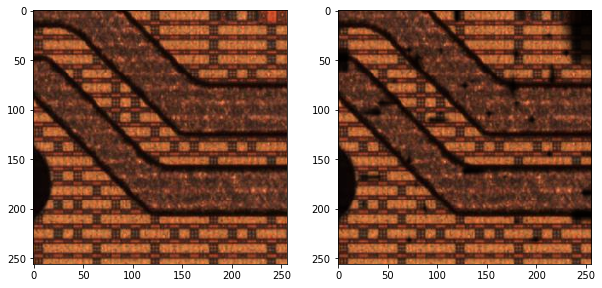

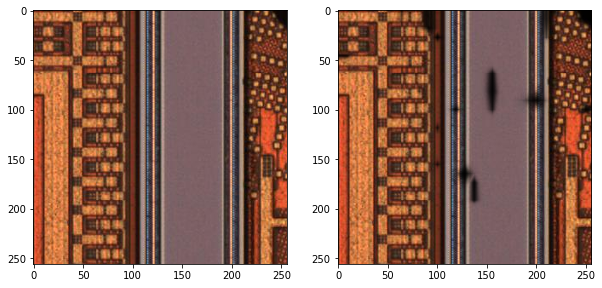

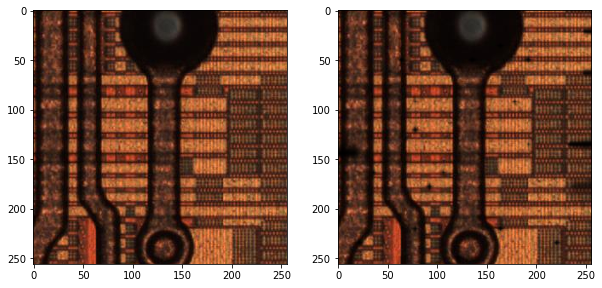

In [14]:
imgaug = aug(PassData[0:20])
for i in range(20):
    plt.figure(figsize = (10,10))
    plt.subplot(1,2,1)
    plt.imshow(PassData[i])
    plt.subplot(1,2,2)
    plt.imshow(imgaug[i])

In [10]:
def train(epochs, batch_size=32, sample_interval=5000):
    
    def aug(data):
#         seq1 = iaa.Sometimes(0.5, iaa.Multiply((0.5,1)))
        seq2 = iaa.SimplexNoiseAlpha(iaa.OneOf([iaa.Add(150), iaa.CoarseDropout((1), size_percent=(1))]),  size_px_max=(5, 25), sigmoid_thresh=7.0, upscale_method="linear")
#         Aug1 = seq1.augment_images(data)
        Aug2 = seq2.augment_images(data)
        return Aug2
    # Configure inputs
    X_train = PassData
    figsize(15,15)

    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        imgsaug = aug(imgs)
        #mask = np.zeros([batch_size, img_rows, img_cols,1])        
        #mask[np.abs(np.mean(imgsaug,axis=3) - np.mean(imgs,axis=3))>10]=255
        mask = np.abs(np.mean(imgsaug,axis=3) - np.mean(imgs,axis=3))
        mask = mask[:,:,:,np.newaxis]
#         mask = np.abs(imgsaug - imgs)
    
#         imgs_HSV = np.zeros((len(idx), 256,256,3))
#         mask_HSV = np.zeros((len(idx), 256,256,3))
#         for i in range(len(idx)):
#             imgs_HSV[i] = cv2.cvtColor(imgs[i], cv2.COLOR_RGB2HSV)
#             mask_HSV[i] = cv2.cvtColor(mask[i], cv2.COLOR_RGB2HSV)
        
#         mask_HSV = np.mean(mask_HSV, axis = 3)
#         mask_HSV = mask_HSV[:,:,:,np.newaxis]
        
        mixedimgs = np.concatenate([imgs, mask],axis=3)
        mixedimgs = mixedimgs/255

        # Generate a half batch of new images
        noise_imgs = noise.predict(mixedimgs)
        
        # Train the denoise
        d_loss = denoise.train_on_batch(noise_imgs, mixedimgs)

        # ---------------------
        #  Train Generator
        # ---------------------

        # Train the noise
        n_loss = combined.train_on_batch(mixedimgs, [mixedimgs, mixedimgs])
        #n_loss = combined.train_on_batch(imgs, [imgs])
        
        #pl.imshow(print_img[0])
        #display.clear_output(wait=True)
        #display.display(pl.gcf())
        
        # Plot the progress
        #print ("%d, N loss (similarity): %f, N loss(unsimilarity): %f, D loss: %f" % (epoch, n_loss[1], n_loss[2], d_loss))

        # If at save interval => save generated image samples
        if epoch % sample_interval == 0:
            nimg = noise.predict(mixedimgs[0:10])
            dimg = denoise.predict(nimg)
            nimg = nimg[:,:,:,:3] * 255
            dimg = dimg[:,:,:,:3] * 255
            nimg = np.asarray(nimg, dtype=np.uint8)
            dimg = np.asarray(dimg, dtype=np.uint8)
            print_img = np.concatenate([imgs[0:10], nimg, dimg], axis=2) 
            print ("%d, N loss (similarity): %f, N loss(unsimilarity): %f, D loss: %f" % (epoch, n_loss[1], n_loss[2], d_loss))
            noise.save('./Model/Unsupervised/HSV_noise/noise'+ str(epoch)+'.h5')
            denoise.save('./Model/Unsupervised/HSV_denoise/denoise'+ str(epoch)+'.h5')
            
            path = "./Data/GAN_Images/HSV/" + str(epoch)
            if os.path.isdir(path):
                for i in range(10):
                    plt.imsave('./Data/GAN_Images/HSV/'+str(epoch)+ "/" + "%d" %(i) + ".png", print_img[i])
            else:
                os.mkdir("./Data/GAN_Images/HSV/" + str(epoch))
                for i in range(10):
                    plt.imsave('./Data/GAN_Images/HSV/'+str(epoch)+ "/" + "%d" %(i) + ".png", print_img[i])

In [11]:
# Input shape
img_rows = 256
img_cols = 256
channels = 3
img_shape = (img_rows, img_cols, channels)

def mask_negative_mean_squared_error(y_true, y_pred):
    y_true = y_true[:,:,:,:3]
    mask = y_pred[:,:,:,3:4]
    prediction = y_pred[:,:,:,:3]
    squared_error = np.square(y_true-prediction)
    masked_error = mask * squared_error
    return -masked_error

def mask_positive_mean_squared_error(y_true, y_pred):
    y_true = y_true[:,:,:,:3]
    mask = y_pred[:,:,:,3:4]
    binary_mask = K.greater(mask,0.04)
    binary_mask = K.cast(binary_mask, dtype='float32')    
    binary_mask = np.abs(binary_mask-1)
    prediction = y_pred[:,:,:,:3]
    squared_error = np.square(y_true-prediction)
    masked_error = binary_mask * squared_error
    return masked_error

optimizer = Adam(0.0001)
#losses = {'noise_img':'mean_squared_error', 'denoise_img':mask_negative_mean_squared_error}
losses = [mask_positive_mean_squared_error, mask_negative_mean_squared_error ]
#losses = ['mean_squared_error']

# Build and compile the discriminator
denoise = build_denoise()
denoise.compile(loss='mean_squared_error',
    optimizer=optimizer)

# Build the generator
noise = build_noise()

# The generator takes noise and the target label as input
# and generates the corresponding digit of that label
oringinal_img = Input(shape=(img_rows, img_cols, channels+1,))

noise_img = noise([oringinal_img])

# For the combined model we will only train the generator
denoise.trainable = False

# The discriminator takes generated image as input and determines validity
# and the label of that image
denoise_img = denoise(noise_img)

#noise_img = Lambda(lambda x: x , name='noise_img')(noise_img)
#denoise_img = Lambda(lambda x: x , name='denoise_img')(denoise_img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model([oringinal_img], [noise_img, denoise_img])
#combined = Model([oringinal_img], [denoise_img])
combined.compile(loss=losses, loss_weights = [0.3,0.7],
    optimizer=optimizer)

In [ ]:
train(epochs=1000000)

/usr/local/lib/python2.7/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0, N loss (similarity): 0.095514, N loss(unsimilarity): -0.000982, D loss: 0.078945
5000, N loss (similarity): 0.000185, N loss(unsimilarity): -0.000160, D loss: 0.000730
10000, N loss (similarity): 0.000096, N loss(unsimilarity): -0.000145, D loss: 0.000647
